## ICARUS Test Pulse System
The ICARUS exeriment has two configurations for injecting test pulses onto the preamplifiers. The internal method of injecting test pulses relies on an internal square wave pulse (frequency = 2 kHz, duty cycle = 50%) with a configurable amplitude (20 mVpp, 150 mVpp). The internal triggers must be enabled by setting a flag in the `icarustpc_standard.fcl` BoardReader FHiCL file in the DAQ. The internal test pulse is injected only on either the odd or even channels, though significant pickup noise is observed in the adjacent ones.

The external method of injecting test pulses requires a function generator to be connected to the test pulse LEMO input on the readout boards themselves and the BoardReader FHiCL to be set to accept external test pulses. This method is more versatile, but ultimately they are very similar.

In each case the test pulse goes through some shaping electronics that are approximately equivalent to a low-pass filter, a 1:10 voltage attenuator (0, 3.3 Vpp -> 0, 330 mVpp), and a differentiator. This introduces some features that we believe are not related to the electronics response.

There is a third option available for injecting test pulses that injects charge further upstream in the electronics chain. There exists a set of inputs on the flange itself (opposite the wire bias connectors) which allows for direct injection of a signal onto the end of a wire via a cable traversing vertically through the detector. This cable attaches to a PCB and couples to each wire through a capacitor printed directly on the board. 

### I. Setup
First we must import the relevant helper functions, set the path for the waveform data, and set the fragment ID. In this case, EW08 (fragment ID 4626) was used for the internal and external test pulses and EW10 (fragment ID 4630) was used for the flange-injected test pulses.

In [1]:
from test_pulse_utilities import average_pulse, average_waveform, compare_average_pulse, plot_single_test_waveform, plot_average_waveform_artdaq, plot_average_pulse_artdaq

path = '/Users/mueller/Downloads/waveforms/'
fragment_ew08 = 4626 # EW08
fragment_ew10 = 4630 # EW10

### II. Average Waveforms
By aligning waveforms and calculating the average we can get a much cleaner image of what the test pulse waveform looks like. The frequencies for all tested pulse-injection methods are such that multiple periods of the wave are observed. The upward and downward edges of the square wave produce the positive and negative lobes of the signal.

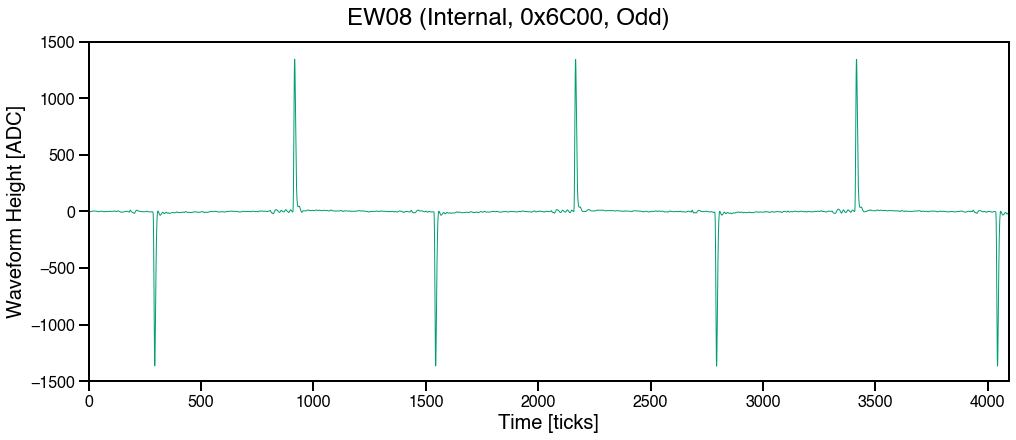

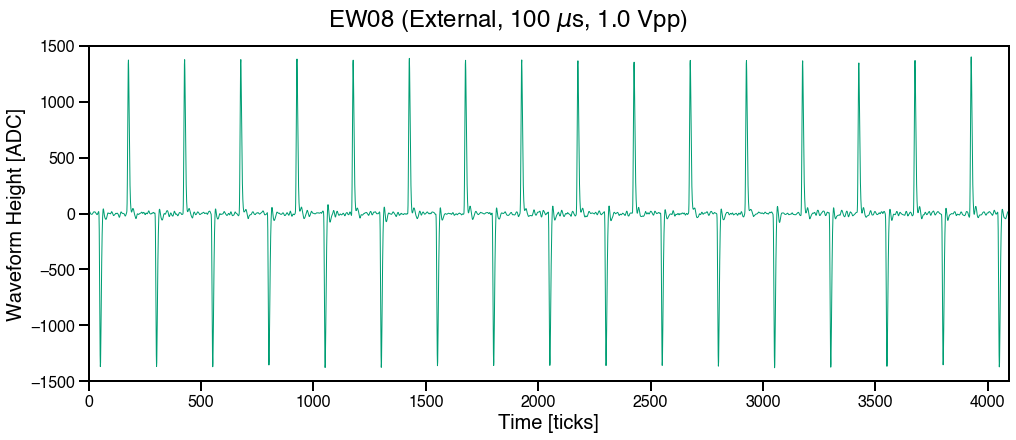

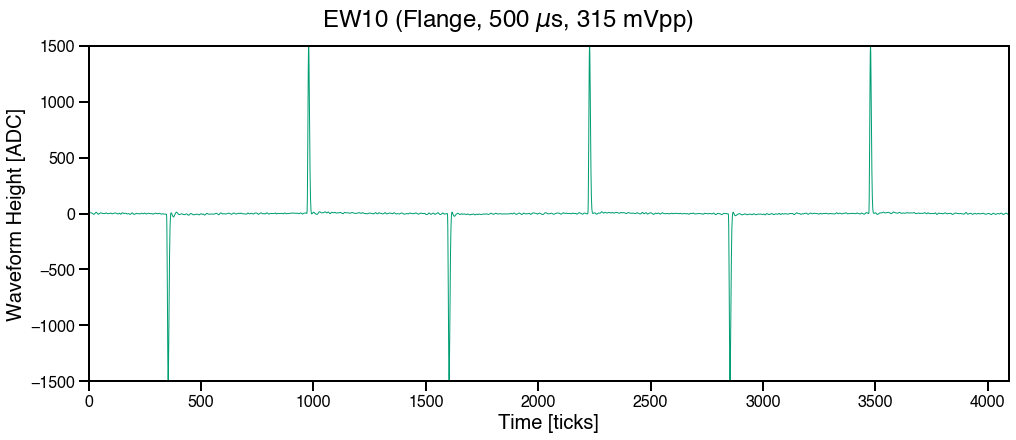

In [2]:
average_waveform(path, 9719, fragment_ew08, 513, 'EW08 (Internal, 0x6C00, Odd)', scale=1500, internal=True)
average_waveform(path, 10222, fragment_ew08, 0, 'EW08 (External, 100 $\mu$s, 1.0 Vpp)', scale=1500, internal=False)
average_waveform(path, 10260, fragment_ew10, 0, 'EW10 (Flange, 500 $\mu$s, 315 mVpp)', scale=1500, nchannels=32)

We observe significant cross talk between adjacent channels, which can best be observed by looking at the non-pulsed channels in the internal test pulse results. Interestingly, the cross talk is itself bipolar and occurs on each downward or upwards edge of the input square wave. The shapes of the cross talk are somewhat different between downward and upwards edges, however.

The external test pulse case can be assumed to suffer from the same cross talk as the internal case since the method is very similar. This cannot be directly assessed since all channels in a single board are necessarily pulsed by this method. We cannot conclude the same for the injection of the test pulse through the flange connectors, and it similarly is not directly testable.

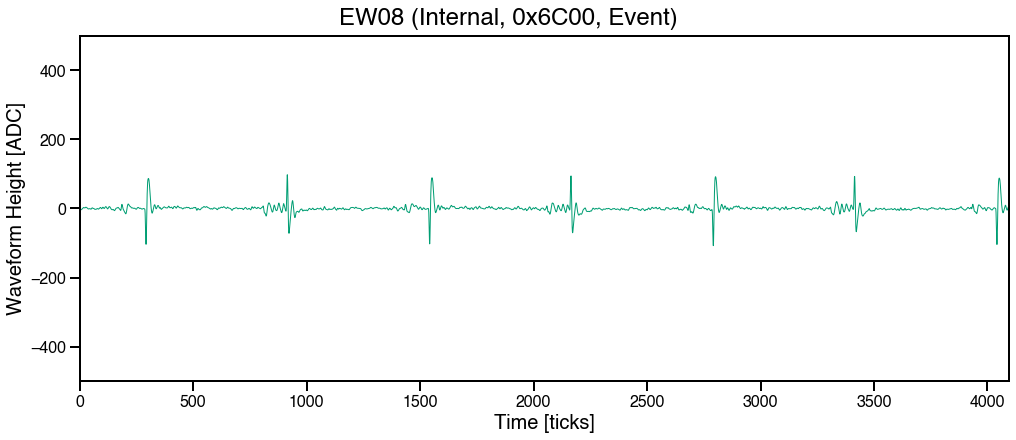

In [3]:
average_waveform(path, 9719, fragment_ew08, 512, 'EW08 (Internal, 0x6C00, Event)', scale=500, internal=True)

### III. Average Pulses
We can also study the pulses themselves in more detail by splitting the waveforms based on the period of the input signal and calculating the average of each resulting piece. The signal coherently adds whereas the noise sums to zero across a sufficiently large sample size. The upward and downward edges are theoretically quite similar, but in practice lead to slightly different pulse shapes due to the shaping electronics and the characteristics of the function generator. 

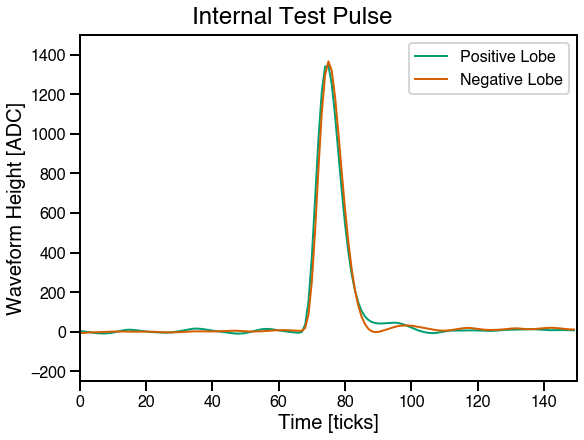

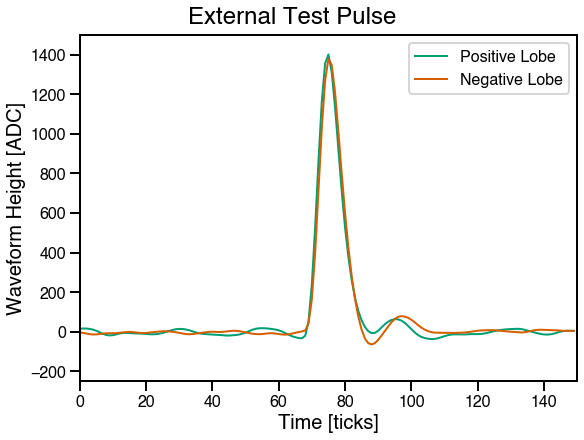

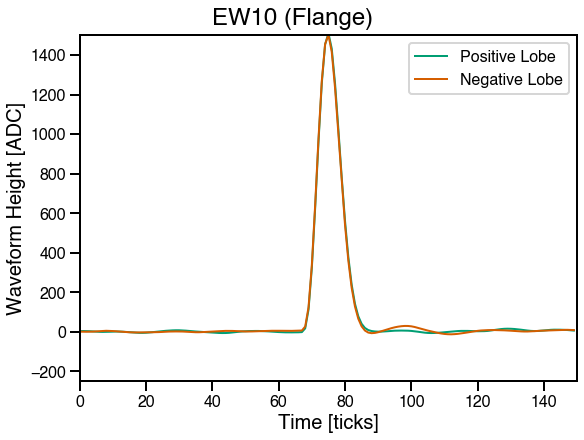

In [4]:
average_pulse(path, 9719, fragment_ew08, 513, 'Internal Test Pulse', scale=1500, internal=True)
average_pulse(path, 10222, fragment_ew08, 0, 'External Test Pulse', scale=1500, internal=False)
average_pulse(path, 10260, fragment_ew10, 0, 'EW10 (Flange)', scale=1500, internal=False, nchannels=32)

We can also compare the average pulse shape of each of the test pulse injection methods.

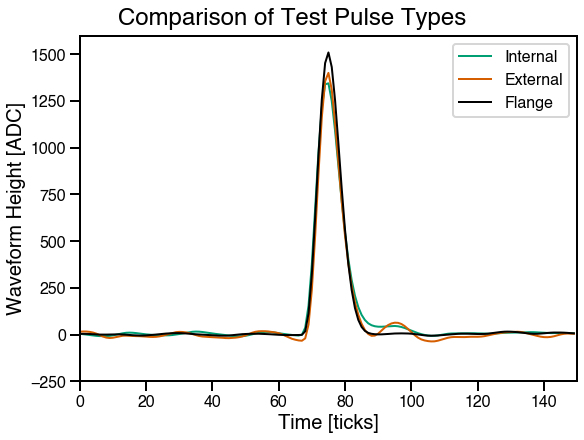

In [5]:
runs = [9719, 10222, 10260]
fragments = [fragment_ew08, fragment_ew08, fragment_ew10]
labels = ['Internal', 'External', 'Flange']
compare_average_pulse(path, runs, fragments, [513, 0, 0], [2, 1, 1], [64, 64, 32], labels, 'Comparison of Test Pulse Types', scale=1600)

## IV. Making Plots with Larger Statistics
A LArSoft module has been prepared to make aggregating larger statistics possible. This module acts on the `PhysCrateFragments` that are placed in the raw data files by the DAQ and extracts the raw waveforms. A simple peak finder is used per waveform to find the first positive peak (with some padding requirement from t = 0), then each successive section (defined by the waveform period) is copied into a histogram. The histogram is a TH2 with integer bin contents to save space and with dimensions (nticks+1, nchannels). The last bin of each channel (e.g. [-1, 25] for channel 25) contains the count of the number of individual sections that have been used to populate the bins.

To use the module output, one generally must load the histogram (key: `tpctestpulseartdaq/output`) using `uproot` or `pyROOT`. In its current state, the TH2 contains a set of bins for each of 576 channels, or one full mini-crate. The channels are enumerated by the order they physically appear in the mini-crate, e.g. the 96th channel is the 32nd channel of the board in the second slot. The number of bins per channel is set to the waveform period + 1 where the last bin is reserved to store information about the count. The waveforms have had no pedestal removal done, so it is best to subtract the median and then normalize by the content of the last bin. A helper function has been written to do exactly this:

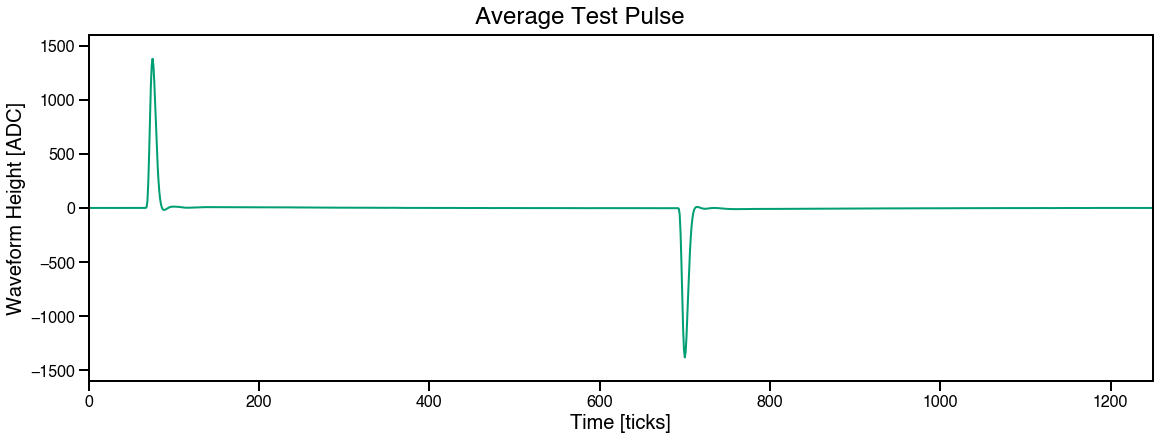

In [6]:
path_artdaq = '/Users/mueller/data/test_pulse/'
plot_average_waveform_artdaq(path_artdaq, 10307, 'Average Test Pulse', 32, 1600)

Similarly, we can extract the positive and negative lobes of the signal from the waveform and plot them:

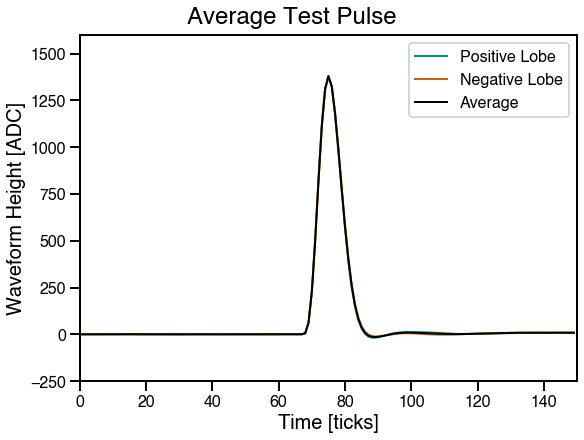

In [7]:
plot_average_pulse_artdaq(path_artdaq, 10307, 'Average Test Pulse', 32, 1600)

## V. Run Documentation
For completeness, I will document here the list of runs taken with the test pulse (internal or external) enabled. In late March, we took data with the internal test pulse:

| Run   | Board   | Period [microseconds] | Amplitude [mVpp]    |
| ----- | ------- | --------------------- | ------------------- |
| 9718  | All     | 500                   | 44.375 + slot*2.031 |
| 9719  | All     | 500                   | 46.407 + slot*2.031 |

And the external test pulse runs (the ones used here) were performed on August 2:

| Run   | Board   | Period [microseconds] | Amplitude [mVpp] |
| ----- | ------- | --------------------- | ---------------- |
| 10214 | TT-Link | 50                    | 3300             |
| 10216 | Board 0 | 50                    | 3300             |
| 10217 | Board 0 | 50                    | 2000             |
| 10218 | Board 0 | 25                    | 3300             |
| 10219 | Board 0 | 10                    | 3300             |
| 10220 | Board 0 | 10                    | 330              |
| 10221 | Board 0 | 100                   | 330              |
| 10222 | Board 0 | 100                   | 1000             |
| 10223 | Board 0 | 100                   | 1000             |

Finally, the runs taken using the flange test pulse inputs:

| Run   | Date        | Crate | Period [microseconds] | Width [microseconds] | Amplitude [mVpp] | Connectors | Splitter | In Phase |
| ----- | ----------- | ----- | --------------------- | -------------------- | ---------------- | ---------- | -------- | -------- |
| 10245 | Aug-08-2023 | EW10  | 250                   | 10                   | 2000             | 1 and 2    |    No    |    Yes   |
| 10246 | Aug-08-2023 | EW10  | 250                   | 10                   | 2000             | 1 and 2    |    No    |    Yes   |
| 10247 | Aug-08-2023 | EW10  | 250                   | 10                   | 5000             | 1 and 2    |    No    |    Yes   |
| 10248 | Aug-08-2023 | EW10  | 250                   | 50                   | 5000             | 1 and 2    |    No    |    Yes   |
| 10249 | Aug-08-2023 | EW10  | 250                   | 50                   | 5000             | 1          |    No    |    Yes   |
| 10250 | Aug-08-2023 | EW10  | 250                   | 50                   | 5000             | 1 and 4    |    No    |    Yes   |
| 10255 | Aug-08-2023 | EW10  | 250                   | 50                   | 180              | 1 and 2    |    No    |    Yes   |
| 10256 | Aug-08-2023 | EW10  | 250                   | 50                   | 180              | 3 and 4    |    No    |    Yes   |
| 10257 | Aug-08-2023 | EW10  | 250                   | 50                   | 180              | 1 and 3    |    No    |    Yes   |
| 10258 | Aug-08-2023 | EW10  | 500                   | 250                  | 315              | 1 and 2    |    No    |    Yes   |
| 10259 | Aug-08-2023 | EW10  | 500                   | 250                  | 315              | 2 and 3    |    No    |    Yes   |
| 10260 | Aug-08-2023 | EW10  | 500                   | 250                  | 315              | 1 and 4    |    No    |    Yes   |
| 10307 | Aug-09-2023 | WE13  | 500                   | 250                  | 315              | 1 and 2    |    No    |    Yes   |
| 10308 | Aug-09-2023 | WE13  | 500                   | 250                  | 315              | 1 and 3    |    No    |    Yes   |
| 10309 | Aug-09-2023 | WE13  | 500                   | 250                  | 315              | 1 and 3    |   Yes    |    Yes   |
| 10357 | Aug-22-2023 | WE13  | 500                   | 250                  | 315              | 3 and 4    |    No    |     No   |
| 10358 | Aug-22-2023 | WE13  | 500                   | 250                  | 315              | 3 and 4    |    No    |     No   |
| 10359 | Aug-22-2023 | WE13  | 500                   | 250                  | 315              | 1 and 2    |    No    |     No   |
| 10366 | Aug-22-2023 | WE13  | 500                   | 250                  | 315              | 1 and 2    |    No    |     No   |
| 10367 | Aug-22-2023 | WE13  | 500                   | 250                  | 315              | 1 and 2    |    No    |    Yes   |
